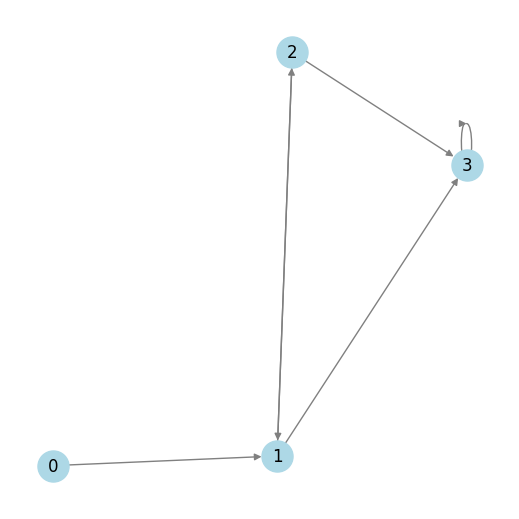

In [89]:
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

# Define edges (source -> target)
edge_index = torch.tensor([[0, 1, 1, 2, 2, 3],  # Source nodes
                           [1, 3, 2, 1, 3, 3]], dtype=torch.long)  # Target nodes

# Create graph data
graph = Data(edge_index=edge_index)

# Convert to NetworkX for visualization
G = nx.DiGraph()
edges = edge_index.t().tolist()
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(5, 5))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=12)
plt.show()

In [5]:
# pip install torch_geometric
# pip install datasets
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

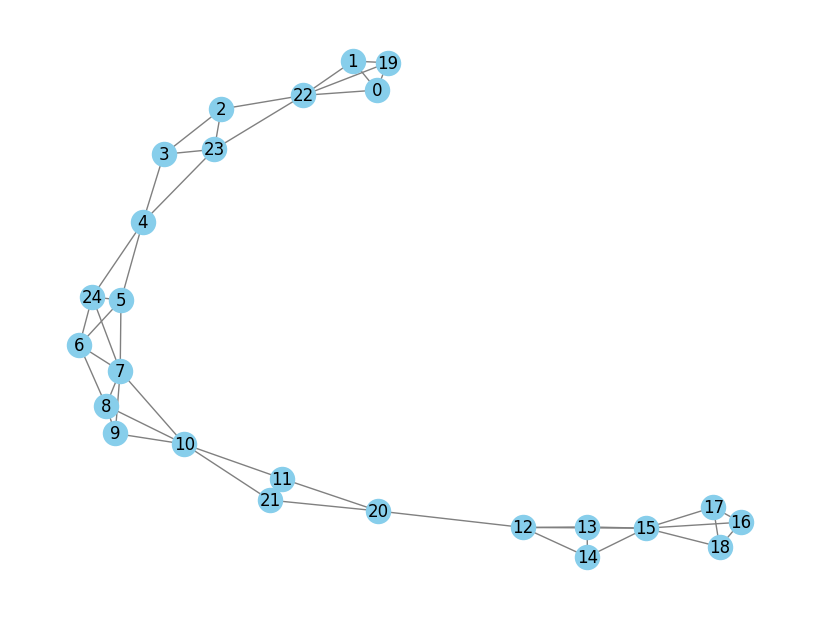

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

data = dataset[2]

G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray')
plt.show()

Network embedding are vector representations of graphs that capture local and global traits; more suitable for standard machine learning techniques (work on vectors rather than graphs). 

Feature-based embeddings are traditionaly used which attempt extract substructures from the graph into numerical form; these however produce sparse solutions as as only few subtructures are common across a graph. Data-driven methods learn optimise some objective function and as a result learn the graph embeddings; and as a result are harder to achieve but are not sparse. 

Random walks are the sequences of nodes, where each new node is selected independently from the set of neighbors of the last node in the sequence. Anonymous random walk remove the global names from each node in the sequence. 

Given a graph $G=(V,E,\Omega)$ where $V=\{v_1,v_2,...,v_n\}$ is a set of vertices, $E\subseteq V\times V$ is a set of edges, and $\Omega \subset\mathbb{R}$ is a set of edge weights; let $s=(u_1,u_2,...,u_k)$ be an ordered list of elements $u_i\in V$, and function $pos:(s,u_i)\rightarrow (p_1,...,p_l)$ return a list of all positions $p_j\in\mathbb{N}$ of $u_i$ occurence in a list $s$. If $s$ is a random walk, then its corresponding anonymous random walk is the sequence of integers $a=(f(v_1),f(v_2),...,f(v_n))$, where $f(v_i)=\min_{p_j\in pos(s,v_i)} pos(s,v_i)$ (for a given walk length, there is a set number fo possible anonymous random walks)

In [7]:

def list_anonymous_walks_of_length_l(l,maxStartValue=0):
    structure = []
    if l <= 0: return structure
    absluteMaxValue = maxStartValue+1
    for i in range(1, absluteMaxValue +1):
        substructure = list_anonymous_walks_of_length_l(l-1, max(i, maxStartValue))
        if len(substructure) <= 0:
            structure.append(i)
            continue
        for element in substructure:
            structure.append(f"{i}-{element}")
    return structure
            
# anonymousWalks11 = list_anonymous_walks_of_length_l(11)
# anonymousWalks11.sort()
# awe11 = dict(zip(anonymousWalks11, [0]*len(anonymousWalks11)))

It has been shown by https://dspace.mit.edu/handle/1721.1/114241 that given the distribution of random walks of length $l$ from a node $u$, $\mathcal{D_l}$ (from it, one can simulate access to the distributions $\mathcal{D_1},...,\mathcal{D_{l-1}}$), reconstruction of $B(v,r)$ is possible; a ball of centre $v$ and radius $r$ (subgraph of $G$ induced by all vertices whose distance from $v$ is at most $r$)

Using this, https://arxiv.org/abs/1805.11921 devised a feature-based and data-driven models for anonymous walk graph embeddings:

## Feature-Based model
Let $\mathcal{A_l}=(a_1,a_2,...,a_\eta)$ be the set of all possible anonymous walks of length $l$; the vector $f_G=(\mathbb{P}(a_1), \mathbb{P}(a_2), ..., \mathbb{P}(a_\eta))$ then will be the anonymous walk embedding of graph $G$.

Where the probability of a anonymous random walk $a_i$, is $\mathbb{P}(a_i)=\frac{1}{N}\sum_{u\in G}\mathbb{P}(a_i^u)=\frac{1}{N}\sum_{u\in G}\sum_{w\rightarrow a_i\in W_l^u}\mathbb{P}(w)$, the sum of all **random walk probabilities** which convert to the same anonymous random walk across all nodes in the graph.

Random walk probability, $\mathbb{P}(w)=\prod_{e\in w}\frac{w_e}{\sum_{v\in N_{\text{out}}}w_{(u,v)}}$; is the probabilty of a given random walk $w$, as the product of the probability of moving across any given edge $w_e$ in $w$.

To achieve this, a running time of $O(nl(d_in^{max}d_out^{max})^{l/2})$ is needed ($d^{max}_{in|out}$ is the maximum in/out degree in graph $G$). However, sampling can be used to generate an empirical distribution $\mathscr{D}^m$ of the original distribution $\mathscr{D}_l$ such that $\mathbb{P}\{||\mathscr{D}^m- \mathscr{D}_l||_1>\epsilon\}\leq \sigma, \epsilon>0, \sigma\in [0,1]$ if the numer of samples are $$m=\lceil \frac{2}{\epsilon^2}(\log(2^\eta-2)-\log(\sigma))\rceil$$

In [8]:
import math

def sampling_size(eta, epsilon=0.1, sigma=0.01):
    return math.ceil(
        2/(epsilon**2)*(math.log(2**eta-2)-math.log(epsilon))
    )

In [32]:
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
l = 7

In [46]:
import random
random.seed(17)

def feature_based_embedding(G,l):

    anonymousWalksList = list_anonymous_walks_of_length_l(l)
    anonymousWalksList.sort()
    awe = dict(zip(anonymousWalksList, [0]*len(anonymousWalksList)))

    m = sampling_size(len(anonymousWalksList))

    for i in range(m):
        currentNode = random.choice(list(G.nodes()))
        pos = {currentNode: 1}
        anonymouswalk = f'{pos[currentNode]}'
        for j in range(1,l):
            currentNode = random.choice(list(G.neighbors(0)))
            pos[currentNode] = pos.get(currentNode, len(pos)+1)
            anonymouswalk += f'-{pos[currentNode]}'
        awe[anonymouswalk] += 1
    return awe

In [47]:
G = to_networkx(dataset[0], to_undirected=True)
feature_based_embedding(G,l)

{'1-1-1-1-1-1-1': 6,
 '1-1-1-1-1-1-2': 30,
 '1-1-1-1-1-2-1': 25,
 '1-1-1-1-1-2-2': 27,
 '1-1-1-1-1-2-3': 23,
 '1-1-1-1-2-1-1': 20,
 '1-1-1-1-2-1-2': 21,
 '1-1-1-1-2-1-3': 23,
 '1-1-1-1-2-2-1': 27,
 '1-1-1-1-2-2-2': 29,
 '1-1-1-1-2-2-3': 25,
 '1-1-1-1-2-3-1': 22,
 '1-1-1-1-2-3-2': 34,
 '1-1-1-1-2-3-3': 24,
 '1-1-1-1-2-3-4': 0,
 '1-1-1-2-1-1-1': 29,
 '1-1-1-2-1-1-2': 26,
 '1-1-1-2-1-1-3': 29,
 '1-1-1-2-1-2-1': 23,
 '1-1-1-2-1-2-2': 27,
 '1-1-1-2-1-2-3': 17,
 '1-1-1-2-1-3-1': 18,
 '1-1-1-2-1-3-2': 29,
 '1-1-1-2-1-3-3': 21,
 '1-1-1-2-1-3-4': 0,
 '1-1-1-2-2-1-1': 32,
 '1-1-1-2-2-1-2': 22,
 '1-1-1-2-2-1-3': 38,
 '1-1-1-2-2-2-1': 21,
 '1-1-1-2-2-2-2': 28,
 '1-1-1-2-2-2-3': 30,
 '1-1-1-2-2-3-1': 20,
 '1-1-1-2-2-3-2': 29,
 '1-1-1-2-2-3-3': 32,
 '1-1-1-2-2-3-4': 0,
 '1-1-1-2-3-1-1': 32,
 '1-1-1-2-3-1-2': 19,
 '1-1-1-2-3-1-3': 28,
 '1-1-1-2-3-1-4': 0,
 '1-1-1-2-3-2-1': 29,
 '1-1-1-2-3-2-2': 36,
 '1-1-1-2-3-2-3': 31,
 '1-1-1-2-3-2-4': 0,
 '1-1-1-2-3-3-1': 34,
 '1-1-1-2-3-3-2': 30,
 '1-1-1-2-3-3-3'

## Data-Driven model
iterate over each vertex $u$ in a graph $G$, sampling $T$ random walks $(w_1^u,w_2^u,...,w_T^u)$ that starts at node $u$ and map to a sequence of **co-occured** anonymous walks $s^u=(a_1^u,a_2^u,...,a_T^u)$. The collection of all $s^u$ for all vertices $u\in G$ is a corpus of co-occured anonymous walks in a graph.

Formally then, a sequence of co-occured anonymous walks $s=(a_1^u,a_2^u,...,a_T^u)$ corresponds to vectors $\text{w}_1,\text{w}_2,...,\text{w}_T$ of anonymous walks matrix $\text{W}\in\mathbb{R}^\eta\times\mathbb{R}^{d_a}$, and a graph $G$ corresponding to vector $\text{d}\in\mathbb{R}^{d_g}$. The model then tries to predict a target anonymous walk given co-occuring context anonymous walks and a graph: $$\max\frac{1}{T}\sum_{t=\Delta}^{T-\Delta}\log\mathbb{P}(\text{w}_t|\text{w}_{t-\Delta},...,\text{w}_{t+\Delta},\text{d})$$ for window size $\Delta$ ($T=k\Delta, k>3$), where the probability is defined objectively via softmax function (requires enough samples such that any given walk $\text{w}_i, i\in \{1,...,\eta\}$ has at least $\Delta$ walks before and after it in the sample sequence) 

$$\mathbb{P}(\text{w}_t|\text{w}_{t-\Delta},...,\text{w}_{t+\Delta},\text{d})=\frac{e^{y(\text{w}_t)}}{\sum_{i=1}^\eta e^{y(\text{w}_i)}}, y(\text{w}_t)=b+U\text{concat}(\frac{1}{2\Delta}\sum_{j=-\Delta}^\Delta\text{w}_{t+j}, \text{d})$$ 
$ b\in\mathbb{R}, U\in\mathbb{R}^{d_a+d_g}$ (softmax parameters)